In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(5)
np.random.seed(5)

Using device: cuda


In [3]:
# x: [N, 2], mu: [N, 2]
def R(x, mu, net):
    x.requires_grad_(True)
    mu.requires_grad_(False)

    u = net(x, mu)  # output shape: [N, 1]

    # Compute the gradient ∇u (i.e. du/dx e du/dy)
    grads = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # shape [N, 2]
    u_x = grads[:, 0].unsqueeze(1)  # du/dx
    u_y = grads[:, 1].unsqueeze(1)  # du/dy

    # Laplacian = d²u/dx² + d²u/dy²
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(u_y.sum(), x, create_graph=True)[0][:, 1].unsqueeze(1)
    laplacian_u = u_xx + u_yy

    # Nonlinear term
    mu0 = mu[:, 0].unsqueeze(1)
    mu1 = mu[:, 1].unsqueeze(1)
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Forcing term g(x)
    x0 = x[:, 0].unsqueeze(1)
    x1 = x[:, 1].unsqueeze(1)
    g = 100 * torch.sin(2 * torch.pi * x0) * torch.cos(2 * torch.pi * x1)

    # Residuo della PDE
    residual = -laplacian_u + nonlinear - g

    return residual

In [4]:
# For all the other epochs, it samples on the point on the domain in which the loss is higher so that he can learn better
def adaptive_sample(model, N_tot=5000, N_sel=1750, N_boundary=150):
    X = torch.rand(N_tot, 2, device=device)
    M = (torch.rand(N_tot, 2, device=device) * 0.9 + 0.1)

    # Compute the residual
    X.requires_grad_(True)
    R_vals = R(X, M, model).detach().abs().cpu().numpy().flatten()  # .detach() spezza il grafo

    idx = np.argsort(R_vals)[-N_sel:]
    x_int = X.detach()[idx]  
    mu_int = M.detach()[idx]

    # Point on the border
    x0 = torch.rand(N_boundary, 1, device=device)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)
    xb = torch.cat([
        torch.cat([x0, zeros], 1),
        torch.cat([x0, ones], 1),
        torch.cat([zeros, x0], 1),
        torch.cat([ones, x0], 1)
    ], 0)
    mu_b = (torch.rand(1, 2, device=device) * 0.9 + 0.1).expand(xb.shape[0], -1)

    return x_int, mu_int, xb, mu_b

In [5]:
# Just for the first epoch
def generate_data(N_domain=1750, N_boundary=150):
    # Points in the domain
    x_in = torch.rand((N_domain, 2))  # [x0, x1] ∈ Ω
    mu_in = (torch.rand((1, 2)) * 0.9 + 0.1).expand(N_domain, -1) # [mu0, mu1] ∈ [0.1, 1]^2

    # Points on the border of the domain (edge of the square)
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)

    xb = torch.cat([
        torch.cat([x0, zeros], dim=1),
        torch.cat([x0, ones], dim=1),
        torch.cat([zeros, x0], dim=1),
        torch.cat([ones, x0], dim=1)
    ], dim=0)

    mu_b = mu_in[:N_boundary*4, :]
    return x_in, mu_in, xb, mu_b

In [ ]:
def train_plot(model, epochs=50000, lr=1e-3, lambda_bc=1.0, patience=7500, delta=1e-4, batch_size=None, save_path="./models"):
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_phys_loss = float('inf')
    best_model_state = None
    best_model_path = None
    epochs_no_improve = 0
    using_lbfgs = False

    loss_history_total = []
    loss_history_phys = []
    loss_history_bc = []
    times_per_epoch = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        x_in, mu_in, xb, mu_b = generate_data()

        if epoch != 0:
            x_in, mu_in, xb, mu_b = adaptive_sample(model)

        x_in = x_in.to(device)
        mu_in = mu_in.to(device)
        xb = xb.to(device)
        mu_b = mu_b.to(device)

        try:
            if not using_lbfgs:
                optimizer.zero_grad()
                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

                loss_total = loss_phys + lambda_bc * loss_bc

                if torch.isnan(loss_total):
                    raise ValueError("NaN detected in Adam loss computation")

                loss_total.backward()
                optimizer.step()

                if loss_phys.item() + delta < best_phys_loss:
                    best_phys_loss = loss_phys.item()
                    best_model_state = model.state_dict()
                    best_model_path = os.path.join(save_path, f"model_best.pth")
                    torch.save(best_model_state, best_model_path)
                    torch.save(best_model_state, "PINNResNet.pth")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                # Interrompe l'allenamento se la total loss è < 1e-4
                if loss_total.item() < 1e-4:
                    final_model_path = os.path.join(save_path, "model_total_loss_e-4.pth")
                    torch.save(model.state_dict(), final_model_path)
                    print(f"\n💾 Total loss reached e-4 at epoch {epoch}. Model saved at {final_model_path}")
                    break

                if loss_bc.item() < 1e-1 and loss_phys.item() < 1e-1:
                    print(f"\nSwitching to LBFGS at epoch {epoch}")
                    using_lbfgs = True
                    optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)
                    if best_model_state:
                        model.load_state_dict(best_model_state)

            else:
                def closure():
                    optimizer.zero_grad()
                    loss_phys_cl = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                    u_b_cl = model(xb, mu_b)
                    loss_bc_cl = mse_loss(u_b_cl, torch.zeros_like(u_b_cl))
                    loss_total_cl = loss_phys_cl + lambda_bc * loss_bc_cl

                    if torch.isnan(loss_total_cl):
                        raise ValueError("NaN detected in LBFGS loss computation")

                    loss_total_cl.backward()
                    return loss_total_cl

                optimizer.step(closure)

                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
                loss_total = loss_phys + lambda_bc * loss_bc

                # Stop training if total loss is below threshold
                if loss_total.item() < 1e-3:
                    final_model_path = os.path.join(save_path, "model_total_loss_e-4.pth")
                    torch.save(model.state_dict(), final_model_path)
                    print(f"\n💾 Total loss reached e-4 at epoch {epoch}. Model saved at {final_model_path}")
                    break

        except ValueError as e:
            print(f"\n❌ Training stopped due to error at epoch {epoch}: {str(e)}")
            if best_model_state:
                print("🔄 Reverting to best model state before NaN.")
                model.load_state_dict(best_model_state)
                torch.save(best_model_state, "model_.pth")
                nan_model_path = os.path.join(save_path, f"model_nan_epoch{epoch}.pth")
                torch.save(model.state_dict(), nan_model_path)
            break

        loss_history_total.append(loss_total.item())
        loss_history_phys.append(loss_phys.item())
        loss_history_bc.append(loss_bc.item())
        times_per_epoch.append(time.time() - start_time)

        if epoch % 500 == 0 or epoch == epochs - 1:
            opt_name = "Adam" if not using_lbfgs else "LBFGS"
            print(f"[{opt_name}] Epoch {epoch} - Total: {loss_total.item():.2e} | PDE: {loss_phys.item():.2e} | BC: {loss_bc.item():.2e}")

        if not using_lbfgs and epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch} | Best PDE loss: {best_phys_loss:.2e}")
            model.load_state_dict(best_model_state)
            break


    final_model_path = os.path.join(save_path, "model_final.pth")
    torch.save(model.state_dict(), final_model_path)

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history_total, label='Total Loss')
    plt.plot(loss_history_phys, label='PDE Loss')
    plt.plot(loss_history_bc, label='BC Loss')
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss trends over training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    total_epochs = len(loss_history_total)
    avg_time = sum(times_per_epoch) / total_epochs
    print(f"\n✅ Training complete: {total_epochs} epochs")
    print(f"⏱ Average time per epoch: {avg_time:.4f} seconds")

    return None

[Adam] Epoch 0 - Total: 2.56e+03 | PDE: 2.56e+03 | BC: 2.50e-02
[Adam] Epoch 500 - Total: 1.37e+01 | PDE: 7.62e+00 | BC: 6.03e+00
[Adam] Epoch 1000 - Total: 8.07e+00 | PDE: 3.80e+00 | BC: 4.26e+00
[Adam] Epoch 1500 - Total: 4.51e+00 | PDE: 1.59e+00 | BC: 2.92e+00
[Adam] Epoch 2000 - Total: 3.37e+00 | PDE: 1.55e+00 | BC: 1.82e+00
[Adam] Epoch 2500 - Total: 2.16e+00 | PDE: 6.99e-01 | BC: 1.46e+00
[Adam] Epoch 3000 - Total: 1.61e+00 | PDE: 3.77e-01 | BC: 1.23e+00
[Adam] Epoch 3500 - Total: 1.72e+00 | PDE: 5.26e-01 | BC: 1.19e+00
[Adam] Epoch 4000 - Total: 1.24e+00 | PDE: 2.16e-01 | BC: 1.02e+00
[Adam] Epoch 4500 - Total: 1.13e+00 | PDE: 2.18e-01 | BC: 9.10e-01
[Adam] Epoch 5000 - Total: 1.00e+00 | PDE: 1.64e-01 | BC: 8.40e-01
[Adam] Epoch 5500 - Total: 8.66e-01 | PDE: 1.60e-01 | BC: 7.06e-01
[Adam] Epoch 6000 - Total: 1.25e+00 | PDE: 5.56e-01 | BC: 6.91e-01
[Adam] Epoch 6500 - Total: 6.44e-01 | PDE: 1.28e-01 | BC: 5.15e-01
[Adam] Epoch 7000 - Total: 5.95e-01 | PDE: 1.24e-01 | BC: 4.71e-01

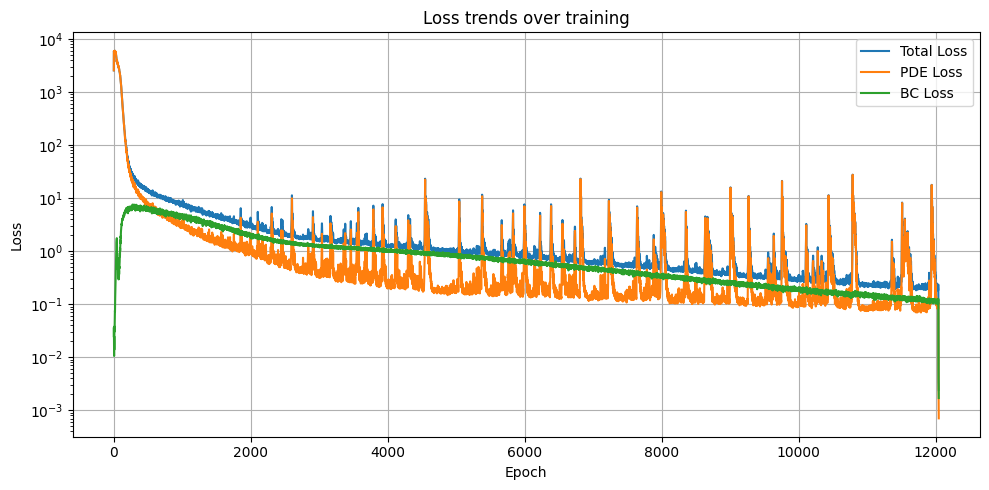


✅ Training complete: 12048 epochs
⏱ Average time per epoch: 0.0196 seconds


In [7]:
# 13- DeepResPINN
class DeepResPINN(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.input = nn.Linear(4, width)
        self.hidden1 = nn.Linear(width, width)
        self.hidden2 = nn.Linear(width, width)
        self.hidden3 = nn.Linear(width, width)
        self.output = nn.Linear(width, 1)
        self.act = nn.Tanh()

    def forward(self, x, mu):
        x = torch.cat((x, mu), dim=1)
        h = self.act(self.input(x))
        h1 = self.act(self.hidden1(h))
        h2 = self.act(self.hidden2(h1) + h)  # skip
        h3 = self.act(self.hidden3(h2) + h1)  # another skip
        return self.output(h3)
        
DeepResPINN = DeepResPINN().to(device)
train_plot(DeepResPINN, epochs = 50000)

torch.save(DeepResPINN.state_dict(), "DeepResPINN.pth")

[Adam] Epoch 0 - Total: 5.35e+05 | PDE: 5.35e+05 | BC: 1.63e-02
[Adam] Epoch 500 - Total: 5.98e+03 | PDE: 5.98e+03 | BC: 1.43e-03
[Adam] Epoch 1000 - Total: 5.84e+03 | PDE: 5.84e+03 | BC: 8.52e-06
[Adam] Epoch 1500 - Total: 6.05e+03 | PDE: 6.05e+03 | BC: 2.17e-04
[Adam] Epoch 2000 - Total: 5.88e+03 | PDE: 5.88e+03 | BC: 8.14e-05
[Adam] Epoch 2500 - Total: 5.87e+03 | PDE: 5.87e+03 | BC: 6.83e-04
[Adam] Epoch 3000 - Total: 5.85e+03 | PDE: 5.85e+03 | BC: 1.47e-03
[Adam] Epoch 3500 - Total: 5.98e+03 | PDE: 5.98e+03 | BC: 5.63e-05
[Adam] Epoch 4000 - Total: 5.92e+03 | PDE: 5.92e+03 | BC: 4.29e-06
[Adam] Epoch 4500 - Total: 5.85e+03 | PDE: 5.85e+03 | BC: 4.82e-04
[Adam] Epoch 5000 - Total: 5.89e+03 | PDE: 5.89e+03 | BC: 2.88e-05
[Adam] Epoch 5500 - Total: 5.81e+03 | PDE: 5.81e+03 | BC: 3.34e-05
[Adam] Epoch 6000 - Total: 5.79e+03 | PDE: 5.79e+03 | BC: 1.31e-04
[Adam] Epoch 6500 - Total: 5.80e+03 | PDE: 5.80e+03 | BC: 7.09e-06
[Adam] Epoch 7000 - Total: 5.69e+03 | PDE: 5.69e+03 | BC: 9.22e-06

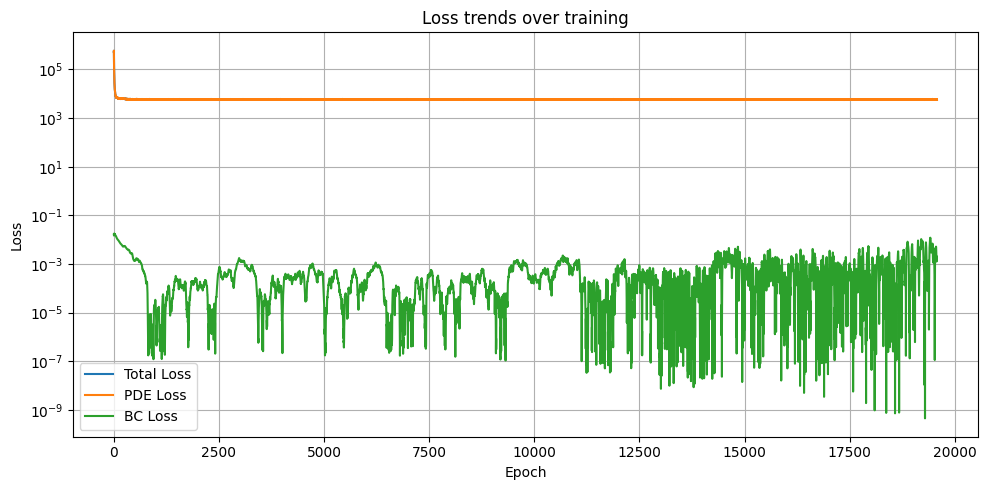


✅ Training complete: 19576 epochs
⏱ Average time per epoch: 0.0161 seconds


In [8]:
# 14- FourierPINN
class FourierPINN(nn.Module):
    def __init__(self, width=60, B=10.0):
        super().__init__()
        self.B = nn.Parameter(B * torch.randn(100, 4), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(200, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )

    def forward(self, x, mu):
        x_in = torch.cat((x, mu), dim=1)
        x_proj = 2 * torch.pi * x_in @ self.B.T
        fourier_feats = torch.cat((torch.sin(x_proj), torch.cos(x_proj)), dim=-1)
        return self.net(fourier_feats)

FourierPINN = FourierPINN().to(device)
train_plot(FourierPINN, epochs = 50000)

torch.save(FourierPINN.state_dict(), "FourierPINN.pth")

[Adam] Epoch 0 - Total: 2.51e+03 | PDE: 2.51e+03 | BC: 0.00e+00
[Adam] Epoch 500 - Total: 3.83e+03 | PDE: 3.83e+03 | BC: 0.00e+00
[Adam] Epoch 1000 - Total: 3.74e+03 | PDE: 3.74e+03 | BC: 0.00e+00
[Adam] Epoch 1500 - Total: 3.15e+03 | PDE: 3.15e+03 | BC: 0.00e+00
[Adam] Epoch 2000 - Total: 1.25e+03 | PDE: 1.25e+03 | BC: 0.00e+00
[Adam] Epoch 2500 - Total: 7.38e+02 | PDE: 7.38e+02 | BC: 0.00e+00
[Adam] Epoch 3000 - Total: 4.05e+02 | PDE: 4.05e+02 | BC: 0.00e+00
[Adam] Epoch 3500 - Total: 2.69e+02 | PDE: 2.69e+02 | BC: 0.00e+00
[Adam] Epoch 4000 - Total: 1.69e+02 | PDE: 1.69e+02 | BC: 0.00e+00
[Adam] Epoch 4500 - Total: 1.10e+02 | PDE: 1.10e+02 | BC: 0.00e+00
[Adam] Epoch 5000 - Total: 6.20e+01 | PDE: 6.20e+01 | BC: 0.00e+00
[Adam] Epoch 5500 - Total: 2.58e+01 | PDE: 2.58e+01 | BC: 0.00e+00
[Adam] Epoch 6000 - Total: 1.00e+01 | PDE: 1.00e+01 | BC: 0.00e+00
[Adam] Epoch 6500 - Total: 4.15e+00 | PDE: 4.15e+00 | BC: 0.00e+00
[Adam] Epoch 7000 - Total: 2.25e+00 | PDE: 2.25e+00 | BC: 0.00e+00

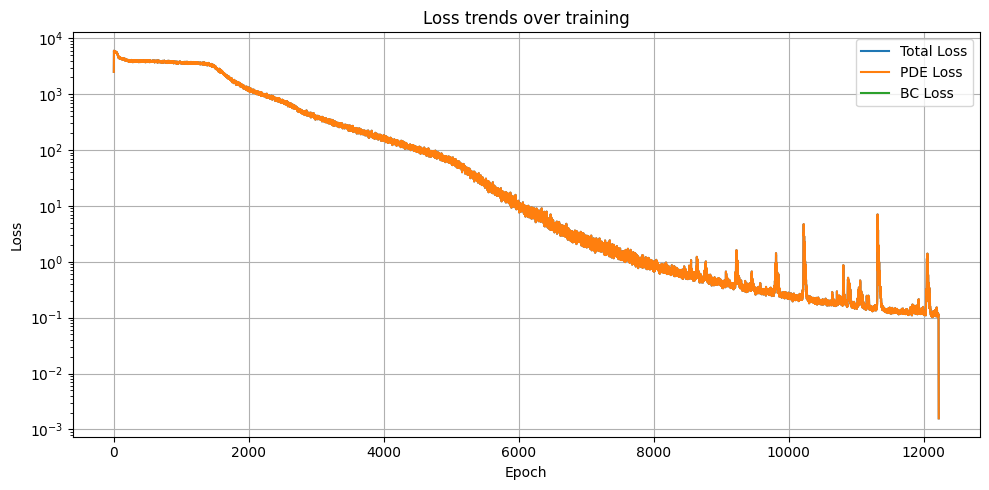


✅ Training complete: 12227 epochs
⏱ Average time per epoch: 0.0228 seconds


In [9]:

# 15- PINNHardBC
def boundary_factor(x):
    return x[:,0]*(1 - x[:,0])*x[:,1]*(1 - x[:,1])  # vanish on boundary

class PINNHardBC(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )
    def forward(self, x, mu):
        xmu = torch.cat((x, mu), dim=1)
        return boundary_factor(x).unsqueeze(1) * self.net(xmu)

PINNHardBC = PINNHardBC().to(device)
train_plot(PINNHardBC, epochs = 50000)

torch.save(PINNHardBC.state_dict(), "PINNHardBC.pth")